100%|██████████| 9.91M/9.91M [00:00<00:00, 15.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]
Epoch 20/20: 100%|██████████| 469/469 [00:11<00:00, 40.13it/s, MSE=0.0706]


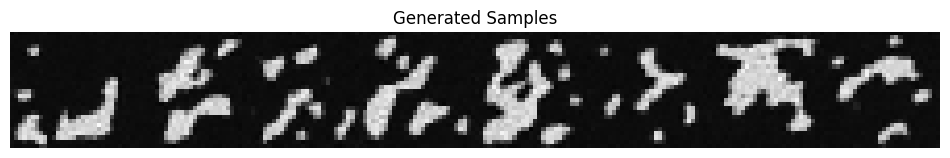

In [1]:
# Diffusion Model: End-to-End Implementation using PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
img_size = 28
batch_size = 128
epochs = 20
learning_rate = 2e-4
T = 300  # Diffusion steps

# Load MNIST
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # Scale to [-1, 1]
])
dataset = datasets.MNIST(root="./data", train=True, transform=data_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Sinusoidal time embeddings
class SinusoidalTimeEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# Simple U-Net style model
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = SinusoidalTimeEmbeddings(32)
        self.fc = nn.Linear(32, 64)

        self.net = nn.Sequential(
           nn.Conv2d(1 + 64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.fc(self.time_embed(t))  # [B, 64]
        t_emb = t_emb[:, :, None, None]  # [B, 64, 1, 1]
        t_emb = t_emb.expand(-1, -1, x.size(2), x.size(3))  # [B, 64, H, W]
        x = torch.cat([x, t_emb], dim=1)  # Concatenate along channels
        return self.net(x)


# Noise schedule
beta = torch.linspace(1e-4, 0.02, T).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

def forward_diffusion_sample(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise, noise

# Training
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        x_noisy, noise = forward_diffusion_sample(x, t)
        noise_pred = model(x_noisy, t)
        loss = loss_fn(noise, noise_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())

# Sampling from model
def sample(model, n_samples):
    model.eval()
    x = torch.randn((n_samples, 1, img_size, img_size), device=device)
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        alpha_t = alpha[t]
        alpha_hat_t = alpha_hat[t]
        beta_t = beta[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * noise_pred) + torch.sqrt(beta_t) * noise
    return x

# Plot results
def show_images(images, title=""):
    images = (images + 1) * 0.5  # Rescale to [0, 1]
    grid = torch.cat([img for img in images], dim=2).squeeze().cpu().detach().numpy()
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

sampled_images = sample(model, 8)
show_images(sampled_images, title="Generated Samples")
